In [2]:
from routedConv2d import OptimizedRoutedConv2d
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [3]:
dataset = load_dataset("cifar100")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

In [4]:
from torchvision import transforms
import torchvision

# compose the transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [12]:
def collate_fn(batch):
    imgs = []
    labels = []
    for i in range(len(batch)):
        img = batch[i]["img"]
        img = transform(torchvision.transforms.ToPILImage()(img).convert("RGB"))
        imgs.append(img)
        labels.append(batch[i]["coarse_label"])
    return {
        "img": torch.stack(imgs),
        "coarse_label": torch.tensor(labels),
    }

In [6]:
import torch.nn as nn
import torch


class SparseMoEConvBlock(nn.Module):
    def __init__(
        self,
        router_dim,
        in_channels,
        num_experts=8,
        top_k=2,
        device="cuda",
    ):
        super().__init__()
        self.num_experts = num_experts
        self.in_channels = in_channels
        self.router_dim = router_dim
        self.top_k = top_k
        self.device = device

        self.router = nn.Linear(router_dim, num_experts, bias=False)
        # initialize the router weights to be random
        nn.init.xavier_uniform_(self.router.weight)
        self.experts = nn.ModuleList(
            [
                nn.Conv2d(in_channels, in_channels, 3, padding=1)
                for _ in range(num_experts)
            ]
        )

        self.register_buffer("experts_used", torch.zeros(num_experts))

    def forward(self, x):
        batch_size, _, height, width = x.shape
        router_logits = self.router(x.view(batch_size, -1))
        router_output = nn.functional.softmax(router_logits, dim=1)

        router_avg = torch.mean(router_output, dim=0)
        target = torch.tensor([1 / self.num_experts] * self.num_experts).to(self.device)
        criterion = nn.MSELoss()
        router_loss = criterion(router_avg, target)

        routing_weights, selected_experts = torch.topk(router_output, self.top_k)

        # Create mask for the selected experts (batch_size, num_experts)
        expert_mask = torch.zeros(batch_size, self.num_experts).to(x.device)
        expert_mask.scatter_(1, selected_experts, 1)

        self.experts_used = self.experts_used.to(x.device)
        self.experts_used += torch.sum(expert_mask, dim=0)

        expert_outputs = torch.zeros(
            batch_size, self.in_channels * self.top_k, height, width
        ).to(x.device)

        for i, expert_idx in enumerate(selected_experts[0]):
            expert_layer = self.experts[expert_idx]
            # We select the corresponding routing weights for the expert
            routing_weights_expert = routing_weights[0, i]

            out = expert_layer(x)
            # out = out * routing_weights_expert.unsqueeze(-1).unsqueeze(-1)

            expert_outputs[:, i * self.in_channels : (i + 1) * self.in_channels] = out

        return expert_outputs, router_loss

    def get_experts_used(self):
        return self.experts_used

    def get_experts_load_balancing_loss(self):
        return torch.std(self.experts_used)

    def reset_experts_used(self):
        self.experts_used = torch.zeros(self.num_experts)


In [7]:
class SparseMoEConvBlockWeighted(nn.Module):
    def __init__(
        self,
        router_dim,
        in_channels,
        out_channels,
        num_experts=8,
        top_k=2,
        kernel_size=3,
        stride=1,
        padding=1,
        device="cuda",
    ):
        super().__init__()
        self.num_experts = num_experts
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.router_dim = router_dim
        self.top_k = top_k
        self.device = device
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.router = nn.Linear(router_dim, num_experts, bias=False)
        # initialize the router weights to be random
        nn.init.xavier_uniform_(self.router.weight)
        self.experts = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=self.kernel_size,
                    stride=self.stride,
                    padding=self.padding,
                )
                for _ in range(num_experts)
            ]
        )

    def forward(self, x):
        batch_size, _, height, width = x.shape
        router_logits = self.router(x.view(batch_size, -1))
        router_output = nn.functional.softmax(router_logits, dim=1)

        router_avg = torch.mean(router_output, dim=0)
        target = torch.tensor([1 / self.num_experts] * self.num_experts).to(self.device)
        criterion = nn.MSELoss()
        router_loss = criterion(router_avg, target)

        routing_weights, selected_experts = torch.topk(router_output, self.top_k)

        expert_outputs = torch.zeros(batch_size, self.out_channels, height, width).to(
            x.device
        )

        for i, expert_idx in enumerate(selected_experts[0]):
            expert_layer = self.experts[expert_idx]
            # We select the corresponding routing weights for the expert
            routing_weights_expert = routing_weights[0, i]

            out = expert_layer(x)
            out = out * routing_weights_expert.unsqueeze(-1).unsqueeze(-1)

            expert_outputs += out

        return expert_outputs, router_loss


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1, 1)
        self.fc1 = nn.Linear(12 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 12 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class RoutedCNN(nn.Module):
    def __init__(self, device="cuda"):
        super(RoutedCNN, self).__init__()
        self.conv1 = SparseMoEConvBlockWeighted(
            router_dim=3 * 32 * 32,
            in_channels=3,
            out_channels=24,
            num_experts=10,
            top_k=1,
        )
        # self.conv2 = SparseMoEConvBlockWeighted(
        #     router_dim=12 * 32 * 32,
        #     in_channels=12,
        #     out_channels=24,
        #     num_experts=10,
        #     top_k=1,
        # )
        self.fc1 = nn.Linear(24 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 100)
        self.device = device

    def forward(self, x, return_router_loss=False):
        x, router_loss_1 = self.conv1(x)
        x = torch.relu(x)
        # x, router_loss_2 = self.conv2(x)
        # x = torch.relu(x)
        x = x.view(-1, 24 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        if return_router_loss:
            return x, router_loss_1  # + router_loss_2
        else:
            return x


In [15]:
train_loader = DataLoader(
    dataset["train"].with_format("torch"),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    dataset["test"].with_format("torch"),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
)

In [17]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report


num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RoutedCNN().to(device)

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["img"].to(device)
        labels = batch["coarse_label"].to(device)

        outputs, router_loss = model(images, return_router_loss=True)
        loss = criterion(outputs, labels)

        # # Compute the load balancing loss
        # load_balancing_loss = 0
        # for module in model.modules():
        #     if isinstance(module, SparseMoEConvBlock):
        #         load_balancing_loss += module.get_experts_load_balancing_loss()
        #         module.reset_experts_used()

        # Combine the losses
        lambda_balance = (
            10  # Adjust this hyperparameter to control the strength of load balancing
        )

        total_loss = loss + lambda_balance * router_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (i + 1) % len(train_loader) == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {total_loss.item():.4f}, Router loss: {router_loss.item():.4f}"
            )

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(test_loader):
            images = batch["img"].to(device)
            labels = batch["coarse_label"].to(device)
            outputs = model(images)
            # for module in model.modules():
            #     if isinstance(module, SparseMoEConvBlock):
            # print(f"Experts used std: {torch.std(module.get_experts_used())}")
            # module.reset_experts_used()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(
            f"F1 score of the model on the test images: {f1_score(labels.cpu(), predicted.cpu(), average='macro')}"
        )
        print(f"Accuracy of the model on the test images: {100 * correct / total}%")


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/10], Step [1563/1563], Loss: 2.5952, Router loss: 0.0126


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.11458333333333333
Accuracy of the model on the test images: 24.62%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/10], Step [1563/1563], Loss: 2.4272, Router loss: 0.0190


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.1952380952380952
Accuracy of the model on the test images: 28.77%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/10], Step [1563/1563], Loss: 1.7068, Router loss: 0.0141


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.04444444444444444
Accuracy of the model on the test images: 30.73%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/10], Step [1563/1563], Loss: 2.1131, Router loss: 0.0087


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.20714285714285713
Accuracy of the model on the test images: 33.99%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/10], Step [1563/1563], Loss: 2.2682, Router loss: 0.0126


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.14444444444444443
Accuracy of the model on the test images: 33.48%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [6/10], Step [1563/1563], Loss: 1.8456, Router loss: 0.0056


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.09777777777777778
Accuracy of the model on the test images: 34.28%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [7/10], Step [1563/1563], Loss: 1.8287, Router loss: 0.0056


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.16041666666666665
Accuracy of the model on the test images: 34.98%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [8/10], Step [1563/1563], Loss: 1.9690, Router loss: 0.0213


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.12037037037037036
Accuracy of the model on the test images: 36.3%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [9/10], Step [1563/1563], Loss: 1.3982, Router loss: 0.0103


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.15625
Accuracy of the model on the test images: 36.48%


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [10/10], Step [1563/1563], Loss: 1.3988, Router loss: 0.0072


  0%|          | 0/313 [00:00<?, ?it/s]

F1 score of the model on the test images: 0.2111111111111111
Accuracy of the model on the test images: 36.86%


In [22]:
torch.save(model.state_dict(), "routed_cnn_100.pth")

In [23]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    preds = []
    targets = []
    for batch in tqdm(test_loader):
        images = batch["img"].to(device)
        labels = batch["coarse_label"].to(device)
        outputs = model(images)
        # for module in model.modules():
        #     if isinstance(module, SparseMoEConvBlock):
        # print(f"Experts used std: {torch.std(module.get_experts_used())}")
        # module.reset_experts_used()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    print(f"Accuracy of the model on the test images: {100 * correct / total}%")
    print(classification_report(targets, preds))

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the model on the test images: 36.86%
              precision    recall  f1-score   support

           0       0.30      0.39      0.34       500
           1       0.34      0.38      0.36       500
           2       0.48      0.65      0.55       500
           3       0.52      0.27      0.35       500
           4       0.42      0.38      0.40       500
           5       0.28      0.35      0.32       500
           6       0.33      0.44      0.37       500
           7       0.34      0.40      0.37       500
           8       0.29      0.20      0.24       500
           9       0.46      0.43      0.44       500
          10       0.46      0.60      0.52       500
          11       0.30      0.25      0.27       500
          12       0.27      0.25      0.26       500
          13       0.11      0.01      0.02       500
          14       0.36      0.56      0.44       500
          15       0.19      0.18      0.19       500
          16       0.24      0.1

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim


def identify_top_experts(model, dataloader, target_class, num_top_experts=2):
    model.eval()
    expert_usage = {i: 0 for i in range(model.conv1.num_experts)}

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["img"]
            labels = batch["coarse_label"]
            inputs, labels = inputs.to(device), labels.to(device)
            mask = labels == target_class
            if not mask.any():
                continue

            target_inputs = inputs[mask]

            # Forward pass through conv1
            router_output = model.conv1.router(
                target_inputs.view(target_inputs.size(0), -1)
            )
            _, selected_experts = torch.topk(router_output, model.conv1.top_k)

            for expert in selected_experts.flatten():
                expert_usage[expert.item()] += 1

    # Sort experts by usage and return top num_top_experts
    sorted_experts = sorted(expert_usage.items(), key=lambda x: x[1], reverse=True)
    return [expert for expert, _ in sorted_experts[:num_top_experts]]


def evaluate_model(model, test_loader, target_class):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        preds = []
        targets = []
        for batch in tqdm(test_loader):
            images = batch["img"].to(device)
            labels = batch["coarse_label"].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

            # Accuracy on target class
        correct_target = 0
        total_target = 0
        for pred, target in zip(preds, targets):
            if target == target_class:
                total_target += 1
                if pred == target:
                    correct_target += 1

        # Accuracy on non-target classes
        correct_non_target = 0
        total_non_target = 0
        for pred, target in zip(preds, targets):
            if target != target_class:
                total_non_target += 1
                if pred == target:
                    correct_non_target += 1

        accuracy_target = 100 * correct_target / total_target
        accuracy_non_target = 100 * correct_non_target / total_non_target
        return accuracy_target, accuracy_non_target, targets, preds


class UnlearningLoss(nn.Module):
    def __init__(self, target_class, penalty_weight=2):
        super().__init__()
        self.target_class = target_class
        self.ce_loss = nn.CrossEntropyLoss()
        self.penalty_weight = penalty_weight

    def forward(self, outputs, labels):
        # Standard cross-entropy loss
        # change labels of target class to random class != target_class
        labels = torch.where(
            labels == self.target_class,
            torch.randint_like(labels, 0, 9),
            labels,
        )

        ce_loss = self.ce_loss(outputs, labels)

        # # Penalize correct classification of target class
        # target_mask = labels == self.target_class
        # if target_mask.any():
        #     target_outputs = outputs[target_mask]
        #     target_loss = -torch.log_softmax(target_outputs, dim=1)[
        #         :, self.target_class
        #     ].mean()
        #     return ce_loss + target_loss

        predicted = torch.argmax(outputs, 1)

        # Penalize correct classification of target class
        correct_target_class_mask = (predicted == labels) & (
            labels == self.target_class
        )

        penalty = correct_target_class_mask.sum() * self.penalty_weight

        return ce_loss + penalty


def unlearning_procedure(
    model,
    train_dataloader,
    test_dataloder,
    target_class,
    num_epochs=20,
    learning_rate=0.001,
):
    # print(model)
    # Identify top experts for the target class
    top_experts = identify_top_experts(model, train_dataloader, target_class)
    # print(f"Top experts for class {target_class}: {top_experts}")

    # Freeze all parameters except the identified experts
    for name, param in model.named_parameters():
        param.requires_grad = False

    for expert_idx in top_experts:
        for param in model.conv1.experts[expert_idx].parameters():
            param.requires_grad = True

    model.conv1.router.weight.requires_grad = True

    model.fc2.weight.requires_grad = True
    # Set up optimizer and loss function
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    unlearning_loss = UnlearningLoss(target_class)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            inputs = batch["img"]
            labels = batch["coarse_label"]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = unlearning_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # print(
        #    f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader):.4f}"
        # )

    # Unfreeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Evaluate the model
    accuracy_target, accuracy_non_target, targets, preds = evaluate_model(
        model, test_dataloder, target_class
    )

    # print("Unlearning procedure completed.")
    # print(f"Accuracy on target class {target_class}: {accuracy_target}%")
    # print(f"Accuracy on non-target classes: {accuracy_non_target}%")
    return accuracy_target, accuracy_non_target


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = RoutedCNN().to(device)
# model.load_state_dict(torch.load("routed_cnn.pth"))

# dataset = load_dataset("cifar10")


# hyperparameters = {
#     "train_dataset_percentage": [5, 25, 50, 100],
#     "num_epochs": [1, 2, 3, 4, 5],
#     "learning_rate": [0.01, 0.001, 0.0001],
#     "target_class": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
# }


test_loader = DataLoader(
    dataset["test"].with_format("torch"),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
)


def unlearn(h_params):
    model = RoutedCNN().to(device)
    model.load_state_dict(torch.load("routed_cnn_100.pth", weights_only=True))

    train_loader = DataLoader(
        dataset["train"]
        .shuffle()
        .select(
            range(
                int(
                    len(dataset["train"]) * (h_params["train_dataset_percentage"] / 100)
                )
            )
        )
        .with_format("torch"),
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn,
    )

    accuracy_target, accuracy_non_target = unlearning_procedure(
        model,
        train_loader,
        test_loader,
        h_params["target_class"],
        num_epochs=h_params["num_epochs"],
        learning_rate=h_params["learning_rate"],
    )

    return accuracy_target, accuracy_non_target


In [32]:
hyperparameters = {
    "train_dataset_percentage": 25,
    "num_epochs": 2,
    "learning_rate": 0.001,
    "target_class": 0,
}

accuracy_target, accuracy_non_target = unlearn(hyperparameters)

  0%|          | 0/313 [00:00<?, ?it/s]

In [33]:
print(f"Accuracy on target class: {accuracy_target}")
print(f"Accuracy on non-target classes: {accuracy_non_target}")

Accuracy on target class: 3.0
Accuracy on non-target classes: 37.37894736842105


In [20]:
import itertools
from tqdm.notebook import tqdm

hyperparameters = {
    "train_dataset_percentage": [5, 25, 50, 100],
    "num_epochs": [1, 2, 3, 4, 5],
    "learning_rate": [0.01, 0.001, 0.0001],
    "target_class": [0],  # , 1, 2, 3, 4, 5, 6, 7, 8, 9],
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*hyperparameters.values()))

# Create a list to store results
results = []

# Iterate over all combinations
for params in tqdm(param_combinations, desc="Grid Search Progress"):
    # Create a dictionary of hyperparameters for this run
    h_params = dict(zip(hyperparameters.keys(), params))

    # Run the unlearn function with the current set of hyperparameters
    accuracy_target, accuracy_non_target = unlearn(h_params)

    # Store the results along with the hyperparameters
    results.append(
        {
            "hyperparameters": h_params,
            "accuracy_target": accuracy_target,
            "accuracy_non_target": accuracy_non_target,
        }
    )

# After the grid search is complete, you can analyze the results
best_result = max(
    results, key=lambda x: ((100 - x["accuracy_target"]) + x["accuracy_non_target"]) / 2
)
print("Best hyperparameters:", best_result["hyperparameters"])
print("Best target accuracy:", best_result["accuracy_target"])
print("Corresponding non-target accuracy:", best_result["accuracy_non_target"])

# You might want to save all results for further analysis
import json

with open("grid_search_results.json", "w") as f:
    json.dump(results, f)

Grid Search Progress:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Best hyperparameters: {'train_dataset_percentage': 100, 'num_epochs': 2, 'learning_rate': 0.001, 'target_class': 0}
Best target accuracy: 0.2
Corresponding non-target accuracy: 53.25555555555555


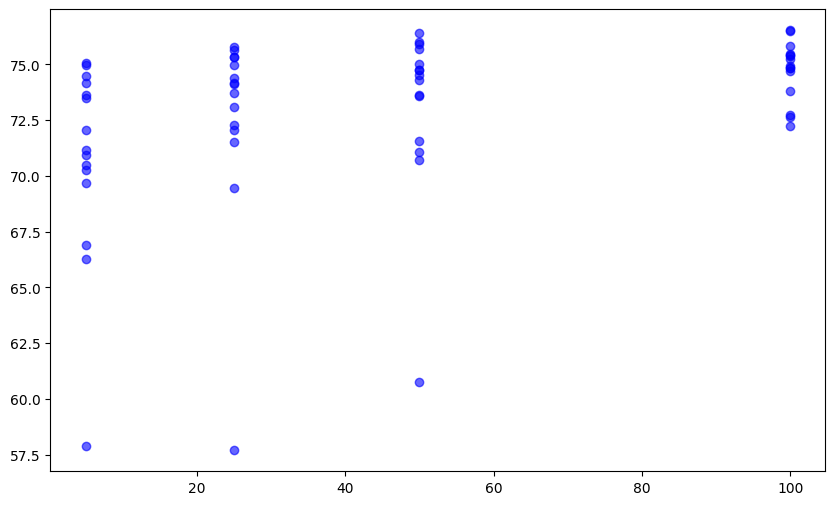

In [28]:
import matplotlib.pyplot as plt

with open("grid_search_results.json", "r") as f:
    results = json.load(f)

    y = [
        ((100 - result["accuracy_target"]) + result["accuracy_non_target"]) / 2
        for result in results
    ]
    x = [result["hyperparameters"]["train_dataset_percentage"] for result in results]


# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c="blue", alpha=0.6)

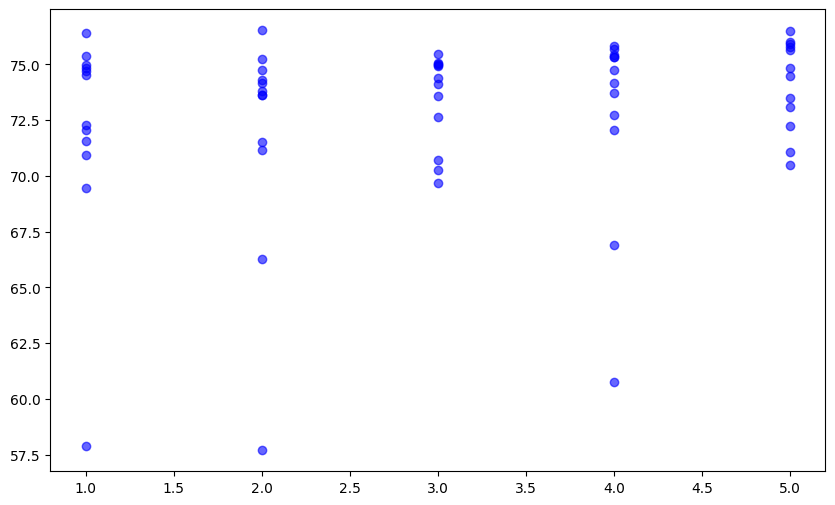

In [29]:
import matplotlib.pyplot as plt

with open("grid_search_results.json", "r") as f:
    results = json.load(f)

    y = [
        ((100 - result["accuracy_target"]) + result["accuracy_non_target"]) / 2
        for result in results
    ]
    x = [result["hyperparameters"]["num_epochs"] for result in results]


# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c="blue", alpha=0.6)

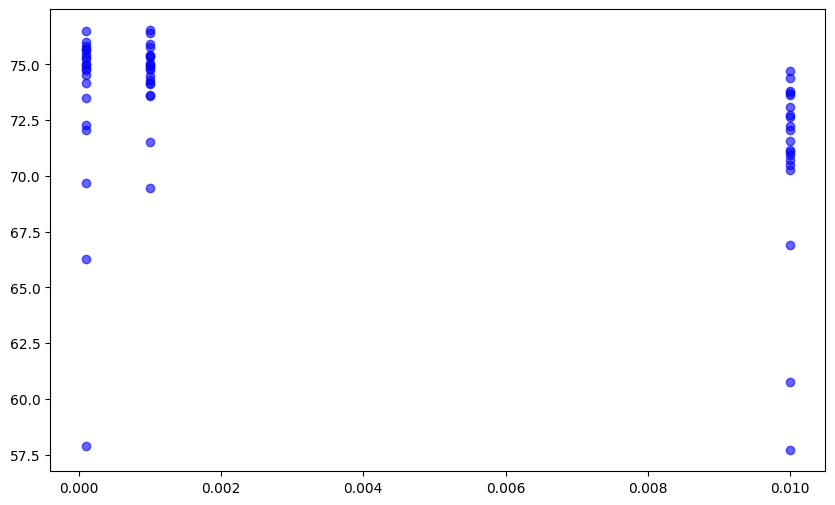

In [30]:
import matplotlib.pyplot as plt

with open("grid_search_results.json", "r") as f:
    results = json.load(f)

    y = [
        ((100 - result["accuracy_target"]) + result["accuracy_non_target"]) / 2
        for result in results
    ]
    x = [result["hyperparameters"]["learning_rate"] for result in results]


# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c="blue", alpha=0.6)

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the data to a pandas DataFrame
data = json.load(open("grid_search_results.json"))
df = pd.DataFrame(data)

# Extract hyperparameters
df["train_dataset_percentage"] = df["hyperparameters"].apply(
    lambda x: x["train_dataset_percentage"]
)
df["num_epochs"] = df["hyperparameters"].apply(lambda x: x["num_epochs"])
df["learning_rate"] = df["hyperparameters"].apply(lambda x: x["learning_rate"])

# Calculate the best score
df["best_score"] = df.apply(
    lambda x: ((100 - x["accuracy_target"]) + x["accuracy_non_target"]) / 2, axis=1
)

# Create a pivot table for the heatmap
pivot_table = df.pivot(index="num_epochs", columns="learning_rate", values="best_score")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={"label": "Best Score"}
)

plt.title("Hyperparameter Sweep: Best Score Heatmap")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Epochs")

# Add text annotation for train_dataset_percentage
plt.text(
    0.5,
    -0.1,
    f"Train Dataset Percentage: {df['train_dataset_percentage'].unique()[0]}%",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.show()

# Print the best hyperparameters
best_row = df.loc[df["best_score"].idxmax()]
print(f"Best Hyperparameters:")
print(f"Train Dataset Percentage: {best_row['train_dataset_percentage']}%")
print(f"Number of Epochs: {best_row['num_epochs']}")
print(f"Learning Rate: {best_row['learning_rate']}")
print(f"Best Score: {best_row['best_score']:.2f}")

ValueError: Index contains duplicate entries, cannot reshape

In [39]:
import plotly.graph_objects as go
import pandas as pd

# Your data
data = json.load(open("grid_search_results.json"))

# Convert the data to a pandas DataFrame
df = pd.DataFrame(
    [
        {
            **item["hyperparameters"],
            "accuracy_target": item["accuracy_target"],
            "accuracy_non_target": item["accuracy_non_target"],
        }
        for item in data
    ]
)

# Calculate the best score
df["best_score"] = ((100 - df["accuracy_target"]) + df["accuracy_non_target"]) / 2

# Create the 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=df["learning_rate"],
            y=df["num_epochs"],
            z=df["train_dataset_percentage"],
            mode="markers",
            marker=dict(
                size=df["best_score"]
                / 2,  # Adjust the division factor to scale the size appropriately
                color=df["best_score"],
                colorscale="Viridis",
                colorbar=dict(title="Best Score"),
                opacity=0.8,
            ),
            text=[
                f"Best Score: {score:.2f}<br>Learning Rate: {lr}<br>Epochs: {epochs}<br>Train %: {train_pct}"
                for score, lr, epochs, train_pct in zip(
                    df["best_score"],
                    df["learning_rate"],
                    df["num_epochs"],
                    df["train_dataset_percentage"],
                )
            ],
            hoverinfo="text",
        )
    ]
)

# Update the layout
fig.update_layout(
    title="3D Hyperparameter Sweep Visualization",
    scene=dict(
        xaxis_title="Learning Rate",
        yaxis_title="Number of Epochs",
        zaxis_title="Train Dataset Percentage",
    ),
    width=800,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
)

# Show the plot
fig.show()

In [47]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report


test_loader = DataLoader(
    dataset["test"].with_format("torch"),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
)


def evaluate_model(model, test_loader, target_class):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        preds = []
        targets = []
        for batch in tqdm(test_loader):
            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

            # Accuracy on target class
        correct_target = 0
        total_target = 0
        for pred, target in zip(preds, targets):
            if target == target_class:
                total_target += 1
                if pred == target:
                    correct_target += 1

        # Accuracy on non-target classes
        correct_non_target = 0
        total_non_target = 0
        for pred, target in zip(preds, targets):
            if target != target_class:
                total_non_target += 1
                if pred == target:
                    correct_non_target += 1

        accuracy_target = 100 * correct_target / total_target
        accuracy_non_target = 100 * correct_non_target / total_non_target
        return accuracy_target, accuracy_non_target, targets, preds


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    preds = []
    targets = []
    for batch in tqdm(test_loader):
        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    # Accuracy on target class
    correct_target = 0
    total_target = 0
    for pred, target in zip(preds, targets):
        if target == target_class:
            total_target += 1
            if pred == target:
                correct_target += 1

    # Accuracy on non-target classes
    correct_non_target = 0
    total_non_target = 0
    for pred, target in zip(preds, targets):
        if target != target_class:
            total_non_target += 1
            if pred == target:
                correct_non_target += 1
    print(
        f"Accuracy of the model on the target images: {100 * correct_target / total_target}%"
    )

    print(
        f"Accuracy of the model on the non-target images: {100 * correct_non_target / total_non_target}%"
    )
    # find indexes of target class
    target_indexes = [i for i, x in enumerate(targets) if x == target_class]

    # remove target class from predictions and targets
    preds = [pred for i, pred in enumerate(preds) if i not in target_indexes]
    targets = [target for i, target in enumerate(targets) if i not in target_indexes]

    print(f"Accuracy of the model on the test images: {100 * correct / total}%")
    print(classification_report(targets, preds, zero_division=0))
    print(
        f"F1 score of the model on the test images: {f1_score(targets, preds, average='macro')}"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the model on the target images: 0.1%
Accuracy of the model on the non-target images: 44.86666666666667%
Accuracy of the model on the test images: 40.39%
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      1000
           2       0.35      0.26      0.30      1000
           3       0.29      0.29      0.29      1000
           4       0.31      0.47      0.37      1000
           5       0.41      0.39      0.40      1000
           6       0.40      0.69      0.51      1000
           7       0.68      0.35      0.46      1000
           8       0.59      0.64      0.61      1000
           9       0.67      0.52      0.58      1000

    accuracy                           0.45      9000
   macro avg       0.48      0.45      0.45      9000
weighted avg       0.48      0.45      0.45      9000

F1 score of the model on the test images: 0.4477874232609709
